In [1]:
# Imports
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import chi2, mutual_info_regression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore');

C:\Users\Biniam\AppData\Local\Temp\ipykernel_21864\596560838.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


### Data preparation for modeling
1. Remove outliers
2. Log trans form numeric features
3. Feature selection
4. One-Hot encode categorical features
5. Model training and validation
6. Hyperparameter tuning
6. Making prediction on test data

In [2]:
# Load the cleaned dataset
df = pd.read_csv('../datasets/cleaned_df.csv')
train_rows, train_cols = df.shape[0], df.shape[1]

print(f"The training dataframe has {train_rows} rows and {train_cols} cols")

The training dataframe has 28143 rows and 23 cols


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28143 entries, 0 to 28142
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   28143 non-null  int64  
 1   Gender                       28143 non-null  object 
 2   Age                          28143 non-null  int64  
 3   Income (USD)                 28143 non-null  float64
 4   Income Stability             28143 non-null  object 
 5   Profession                   28143 non-null  object 
 6   Type of Employment           28143 non-null  object 
 7   Location                     28143 non-null  object 
 8   Loan Amount Request (USD)    28143 non-null  float64
 9   Current Loan Expenses (USD)  28143 non-null  float64
 10  Expense Type 1               28143 non-null  object 
 11  Expense Type 2               28143 non-null  object 
 12  Dependents                   28143 non-null  float64
 13  Credit Score    

Preprocess the data for modeling

In [4]:
class ModelDataProcess:
    def __init__(self, df):
        self.df = df

    def remove_outliers(self, feat_with_outliers):
        if set(feat_with_outliers).issubset(self.df.columns):
            Q1 = self.df[feat_with_outliers].quantile(0.25)
            Q3 = self.df[feat_with_outliers].quantile(0.75)
            IQR = Q3 - Q1
            self.df = self.df[~((self.df[feat_with_outliers] < (Q1 - 1.5 * IQR)) | (self.df[feat_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
            return self.df
        else:
            print("One or more features are not in the dataframe")

    def drop_features(self, cols_to_drop_train):
        if set(cols_to_drop_train).issubset(self.df.columns):
            self.df = self.df.drop(cols_to_drop_train, axis=1)
            return self.df
        else:
            print("One or more features are not in the dataframe")
            return self.df
    
    def log_transform_numeric_features(self, numeric_features):
        if set(numeric_features).issubset(self.df.columns):
            for feature in numeric_features:
                self.df[feature] = round(np.log1p(self.df[feature]), 3)
            return self.df
        else:
            print("One or more features are not in the dataframe")
            return self.df
        
    def one_hot_encode(self, col):
        if set(col).issubset(self.df.columns):
            self.df[col] = self.df[col].replace({'F': 0, 'M': 1})
            return self.df
        else:
            print("One or more features are not in the dataframe")
        return self.df
        
    def labelEncoder_columns(self, one_hot_enc_ft):
        if set(one_hot_enc_ft).issubset(self.df.columns):
            labelencoder_mapping = {}
            for col in one_hot_enc_ft:
                labelencoder = LabelEncoder()
                encoded_values = labelencoder.fit_transform(self.df[col])
                self.df[col] = encoded_values
                labelencoder_mapping[col] = {encoded_val: orig_val for orig_val, encoded_val in zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_))}
            return labelencoder_mapping, self.df
        else:
            print("One or more features are not in the dataframe")
        return self.df

        

model_data_process = ModelDataProcess(df)
numeric_cols = ['Income (USD)', 'Current Loan Expenses (USD)', 
                'Loan Amount Request (USD)', 'Property Price', 'Credit Score']
model_data_process.remove_outliers(numeric_cols)

cols_to_drop_train = ['Unnamed: 0', 'Loan Sanctioned', 'Income (USD)_Category', 
                      'Type of Employment']
model_dff = model_data_process.drop_features(cols_to_drop_train)
model_data_process.log_transform_numeric_features(numeric_cols)

one_hot_enc_ft = ['Gender']
model_data_process.one_hot_encode(one_hot_enc_ft)
labeled_cols = ['Profession', 'Income Stability', 'Expense Type 1', 'Property Location',
                'Expense Type 2', 'Location', 'Has Active Credit Card', 'Property Type']
mapping_df, preprocessed_df = model_data_process.labelEncoder_columns(labeled_cols)

In [5]:
# Mapped features values
mapping_df

{'Profession': {0: 'Commercial associate',
  1: 'Other',
  2: 'Pensioner',
  3: 'State servant',
  4: 'Working'},
 'Income Stability': {0: 'High', 1: 'Low'},
 'Expense Type 1': {0: 'N', 1: 'Y'},
 'Property Location': {0: 'Rural', 1: 'Semi-Urban', 2: 'Urban'},
 'Expense Type 2': {0: 'N', 1: 'Y'},
 'Location': {0: 'Rural', 1: 'Semi-Urban', 2: 'Urban'},
 'Has Active Credit Card': {0: 'Active',
  1: 'Inactive',
  2: 'Unknown',
  3: 'Unpossessed'},
 'Property Type': {0: 'Property_type_4',
  1: 'property_type_1',
  2: 'property_type_2',
  3: 'property_type_3'}}

Feature selection

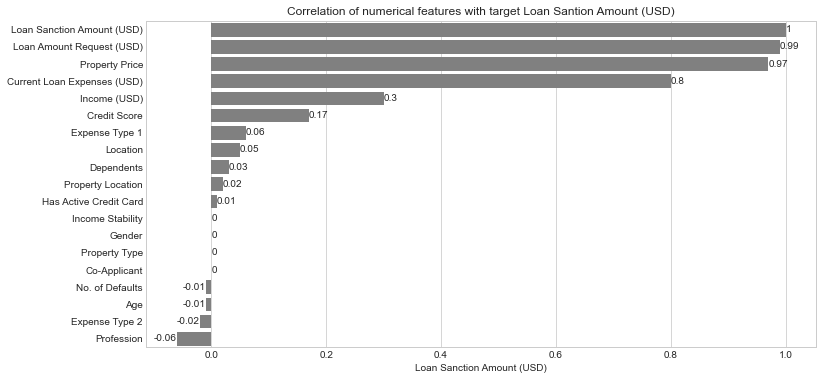

In [6]:
reg_index = preprocessed_df[preprocessed_df['Loan Sanction Amount (USD)'] > 0].index
corr_features = preprocessed_df.loc[reg_index].corr('spearman')

plt.figure(figsize=(12, 6))
corr_target = corr_features['Loan Sanction Amount (USD)'].sort_values(ascending=False)

ax = sns.barplot(x=np.round(corr_target, 2), y=corr_target.index, color='gray')
ax.bar_label(ax.containers[0])

plt.title("Correlation of numerical features with target Loan Santion Amount (USD)")
plt.show()

In [7]:
# Split the data 70% training and 30% testing df
def split_train_test_sets(df, target_col):
        X = df.drop(target_col, axis=1)
        y = df[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        return X_train, X_test, y_train, y_test

target_col = 'Loan Sanction Amount (USD)'
X_train, X_test, y_train, y_test = split_train_test_sets(model_dff, target_col)
print(f'Shape of training set {X_train.shape}, {y_train.shape}')
print(f'Shape of testing set {X_test.shape}, {y_test.shape}')

Shape of training set (18070, 18), (18070,)
Shape of testing set (7745, 18), (7745,)


In [8]:
# Models to compare
Regressors = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42)
}

Cross validation

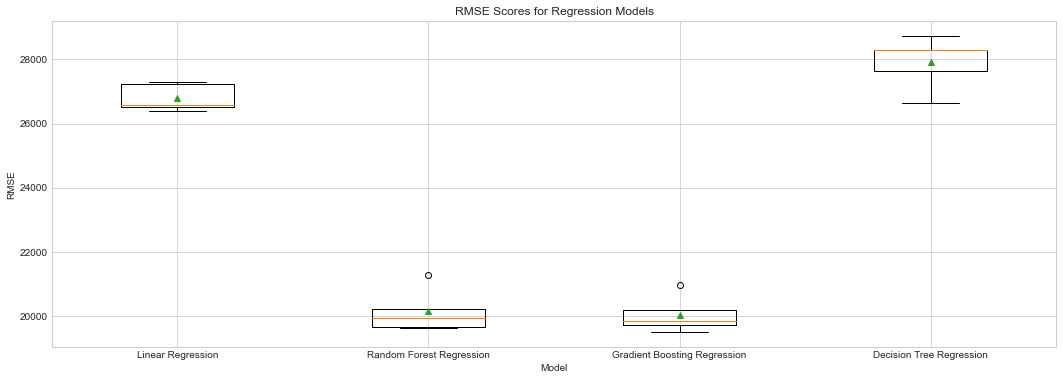

Model: Linear Regression, RMSE: 26805.3300, 95% Confidence Interval: (26284.923177750316, 27325.740144811884)
Model: Random Forest Regression, RMSE: 20154.6700, 95% Confidence Interval: (19309.774880355333, 20999.564402882308)
Model: Gradient Boosting Regression, RMSE: 20052.6900, 95% Confidence Interval: (19342.359623798242, 20763.027578748595)
Model: Decision Tree Regression, RMSE: 27924.0600, 95% Confidence Interval: (26918.97824652058, 28929.143302466226)


0

In [9]:
def evaluate_regression_models(X_train, y_train, models):
    """
    Train and evaluate multiple regression models using cross-validation.

    Parameters:
        X_train (numpy array or pandas DataFrame): The feature matrix of the training set.
        y_train (numpy array or pandas Series): The target variable of the training set.
        models (dict): A dictionary containing regression models to evaluate.
                       The keys should be model names, and the values should be instances of the regression models.

    Returns:
        dict: A dictionary containing the names of the models as keys and their RMSE scores as values.
    """

    rmse_scores = {}

    for model_name, model in models.items():
        # Perform cross-validation with 5 folds
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
        rmse_scores[model_name] = np.sqrt(-scores)

    # Calculate 95% confidence intervals for each model
    confidence_intervals = {}
    for model_name, scores in rmse_scores.items():
        confidence_intervals[model_name] = stats.t.interval(0.95, len(scores)-1, loc=np.mean(scores), scale=stats.sem(scores))

    # Plot the results with a box plot
    plt.figure(figsize=(18, 6))
    plt.boxplot(list(rmse_scores.values()), labels=list(rmse_scores.keys()), showmeans=True)
    plt.xlabel('Model')
    plt.ylabel('RMSE')
    plt.title('RMSE Scores for Regression Models')
    plt.show()

    # Print 95% confidence intervals
    for model_name, interval in confidence_intervals.items():
        print(f"Model: {model_name}, RMSE: {round(np.mean(rmse_scores[model_name]),2):.4f}, 95% Confidence Interval: {interval}")

    return 0
evaluate_regression_models(X_train, y_train, Regressors)

RandomForestRegressor

In [10]:
# Define the hyperparameter grid for Random Forest Regressor
rf_param_grid = {
    'n_estimators': [100, 200, 400, 600, 800, 1000],
    'max_depth': [None, 5, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Create the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Perform random grid search for Random Forest Regressor
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid,
                                      n_iter=10, cv=5, random_state=42, n_jobs=-1)

# Fit the random grid search to the training data
rf_random_search.fit(X_train, y_train)

# Get the best Random Forest Regressor model with optimized hyperparameters
best_rf_model = rf_random_search.best_estimator_
print(best_rf_model)

RandomForestRegressor(max_depth=10, max_features='auto', n_estimators=800,
                      random_state=42)


GradientBoostingRegressor

In [11]:
# Define the hyperparameter grid for Gradient Boosting Regressor
gb_param_grid = {
    'n_estimators': [100, 200, 400, 600, 800, 1000],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Create the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(random_state=42)

# Perform random grid search for Gradient Boosting Regressor
gb_random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=gb_param_grid,
                                      n_iter=10, cv=5, random_state=42, n_jobs=-1)

# Fit the random grid search to the training data
gb_random_search.fit(X_train, y_train)

# Get the best Gradient Boosting Regressor model with optimized hyperparameters
best_gb_model = gb_random_search.best_estimator_
print(best_gb_model)

GradientBoostingRegressor(learning_rate=0.01, max_depth=9, max_features='sqrt',
                          min_samples_leaf=4, min_samples_split=10,
                          n_estimators=400, random_state=42)


In [12]:
def compare_best_models(X_train, y_train, X_test):
    # Train the first model (Random Forest Regressor)
    rf_model = RandomForestRegressor(max_depth=10, min_samples_leaf=1,
                                    min_samples_split=10, max_features='auto',
                                     n_estimators=800, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Train the second model (Gradient Boosting Regressor)
    gb_model = GradientBoostingRegressor(learning_rate=0.01, max_depth=9, max_features='sqrt',
                                         min_samples_leaf=4, min_samples_split=10,
                                         n_estimators=400, random_state=42)
    gb_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    rf_preds = rf_model.predict(X_test)
    gb_preds = gb_model.predict(X_test)
    
    
    return rf_model, rf_preds, gb_model, gb_preds

rf_model, rf_preds, gb_model, gb_preds = compare_best_models(X_train, y_train, X_test)
 # Calculate the RMSE scores for both models
rf_rmse  = np.sqrt(mean_squared_error(y_test, rf_preds))
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_preds))

print("Random Forest RMSE:", rf_rmse)
print("Gradient Boosting RMSE:", gb_rmse)

Random Forest RMSE: 19505.513667696745
Gradient Boosting RMSE: 19525.17232010765


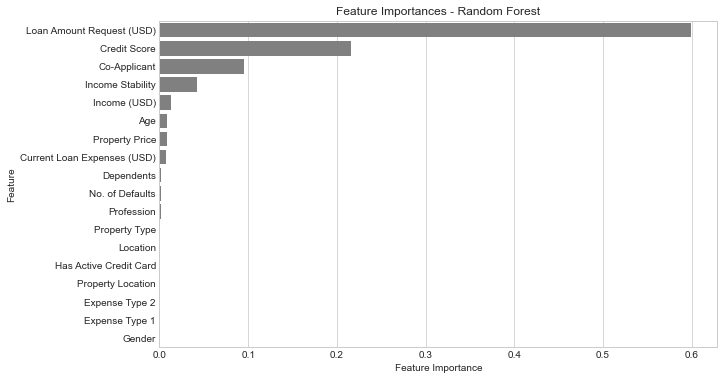

In [13]:
def plot_feature_importances(model, X_train, model_name):

    if len(X_train.columns) != len(model.feature_importances_):
        raise ValueError("The number of features in X_train must be equal to the number of feature importances.")

    # Get the feature importances from the model
    importances = model.feature_importances_

    # Sort the features based on their importances in descending order
    indices = np.argsort(importances)[::-1]
   
    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=X_train.columns[indices], color='gray')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importances - {model_name}')
    plt.show()

plot_feature_importances(rf_model, X_train, 'Random Forest')


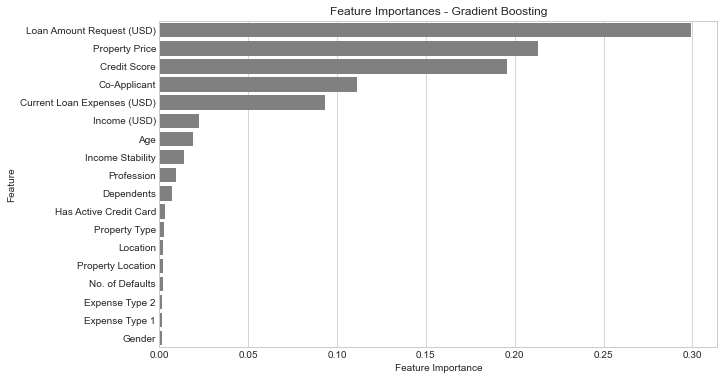

In [14]:
plot_feature_importances(gb_model, X_train, 'Gradient Boosting')

In [15]:
final_model = RandomForestRegressor(max_depth=10, min_samples_leaf=1, 
                                     min_samples_split=10, max_features='auto',
                                     n_estimators=800, random_state=42)
final_model.fit(X_train, y_train)
final_preds = final_model.predict(X_test)
final_rmse  = np.sqrt(mean_squared_error(y_test, final_preds))
print("Random Forest RMSE:", final_rmse)

Random Forest RMSE: 19505.513667696745


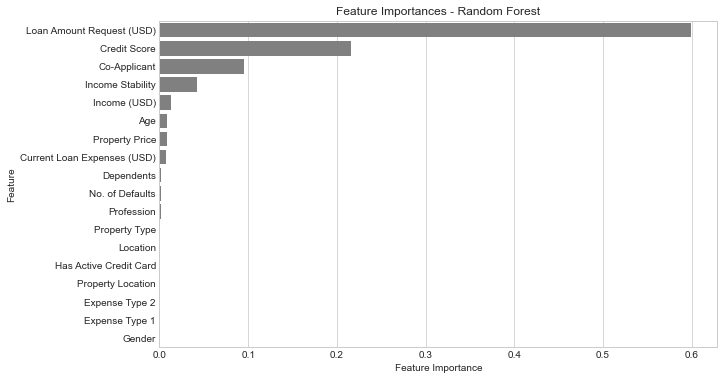

In [16]:
plot_feature_importances(final_model, X_train, 'Random Forest')

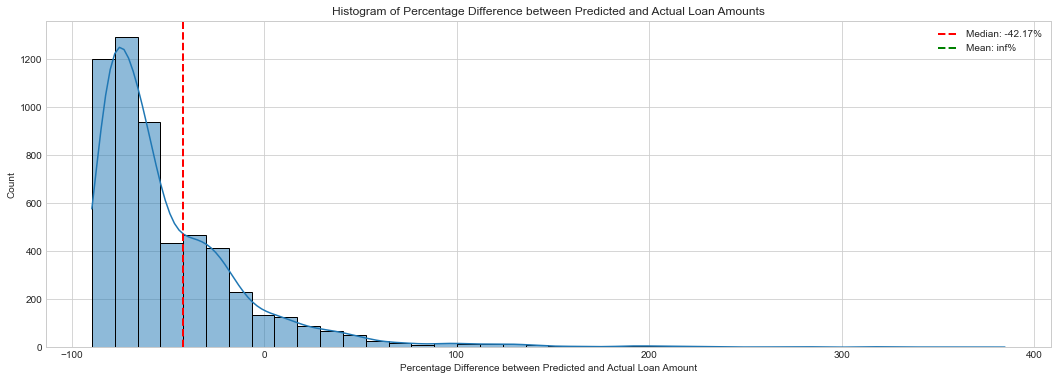

In [17]:
def plot_diff_histogram(predictions_df):
    predictions_df['Percentage_Diff'] = (predictions_df['Predicted_Loan'] - predictions_df['Loan']) / predictions_df['Loan'] * 100

    plt.figure(figsize=(18, 6))
    sns.histplot(predictions_df['Percentage_Diff'], bins=40, kde=True)

    median_diff = predictions_df['Percentage_Diff'].median()
    mean_diff = predictions_df['Percentage_Diff'].mean()
    plt.axvline(median_diff, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_diff:.2f}%')
    plt.axvline(mean_diff, color='green', linestyle='dashed', linewidth=2, label=f'Mean: {mean_diff:.2f}%')

    plt.xlabel('Percentage Difference between Predicted and Actual Loan Amount')
    plt.ylabel('Count')
    plt.title('Histogram of Percentage Difference between Predicted and Actual Loan Amounts')

    plt.legend()
    plt.show()

X_test['Predicted_Loan'] = final_rmse
X_test['Loan'] = y_test
lr_e = X_test    
plot_diff_histogram(lr_e)


Saving the model

In [18]:
pickle.dump(final_model, open('../Model/RF_Regressor.pkl', 'wb'))